## Reading the .csv containing the file names and the steering angles

### Loading the file names  and steering angles into samples
### Splitting samples into train and validation samples

In [1]:
import os
def  extractFileName ( ssd_folder, abs_path):
#     print (abs_path)

    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
        
    if '\\' in abs_path:
        # "  Windows Path " 
#         print ("windows path ")
        image_name = ssd_folder\
                    +split_char + abs_path.split ('\\')[-2] \
                    + split_char +abs_path.split ('\\')[-1]
#         print (image_name)

    else:
        # "  Unix Path " 
        image_name = ssd_folder \
                     + split_char + abs_path.split ('/')[-2] \
                     + split_char + abs_path.split ('/')[-1]
#         print ( "image_name = " + image_name)
    
    return image_name

### Copy data folder to ssd

In [2]:
ssd_folder = "/ssd_data/project3"

In [3]:
# import shutil 

# shutil.rmtree(ssd_folder)
# print ( "Copying files to ssd ....")
# shutil.copytree ("data",ssd_folder)
# print ( "... completed")



### Defining the Sample Pytable

In [6]:
from  tables import *
import tables

hdf5_file = open_file(ssd_folder + "/samples.hdf5", mode = "w", title = "Samples")


ValueError: The file '/ssd_data/project3/samples.hdf5' is already opened.  Please close it before reopening in write mode.

#### Defining the resize shape of the images ( this parameter will be used also in the Generator and in the Model definition)

In [7]:
resized_shape = 128

In [8]:
## Defining the batch size:
batch_size = 128

### Defining the Queue loader chunk size  
queue_loader_chunk = 100 # batch_size(32) * 1000 samples, = 32000 images


### Defining the two objects as images container:


In [9]:
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting .... ")
samples_list = []
center_image_before = None
for name in glob.glob(ssd_folder + "/*.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                # STEERING ANGLE CALCULATION
                samples_list.append([extractFileName(ssd_folder, line[0]),\
                                     extractFileName(ssd_folder, line[1]),\
                                     extractFileName(ssd_folder, line[2]),\
                                     float(line[3])])
                
samples_list = np.array(samples_list)

# from random import shuffle
# shuffle(samples_list)

train_list = samples_list[0:int(0.8*len(samples_list))]

val_list = samples_list[int(0.8*len(samples_list)):int(1.0*len(samples_list))]


print ("\n\nThere are {} images in total ".format(len(samples_list)))
print ("....splitted into training images = {}  ".format(len(train_list)))
print ("                  val images      = {}  ".format(len(val_list)))


Starting .... 
Reading from logfile = /ssd_data/project3/run5.csv
Reading from logfile = /ssd_data/project3/run3.csv
Reading from logfile = /ssd_data/project3/run4.csv
Reading from logfile = /ssd_data/project3/track1_run1.csv
Reading from logfile = /ssd_data/project3/run2.csv
Reading from logfile = /ssd_data/project3/run1.csv


There are 15909 images in total 
....splitted into training images = 12727  
                  val images      = 3182  


In [10]:
# train_list = train_list[3400:3700 ]
# train_list.shape

In [11]:
# val_list = val_list[0:10]
# val_list.shape

In [34]:
def data_preprocess(line):
        preprocessed_samples=[]
        # STEERING ANGLE CALCULATION
        correction = 0.2 # 0.03 # this is a parameter to tune
        center_steering = float(line[3])
        left_steering   = center_steering + correction
        right_steering  = center_steering - correction

        # CENTER IMAGE
        center_image = cv2.imread(extractFileName( ssd_folder, line[0]))
#         print (extractFileName(ssd_folder,  line[0]))
        center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
        center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([center_image, center_steering ])

        #   LEFT IMAGE
        left_image = cv2.imread(extractFileName(ssd_folder,  line[1]))
        left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
        left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([left_image, left_steering ])

        #   RIGHT IMAGE
        right_image = cv2.imread(extractFileName(ssd_folder,  line[2]))
        right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
        right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([right_image, right_steering ])


#         ###
#         ### IMAGE AUGMENTATION
#         ###
#         # augmented center image
#         preprocessed_samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

#         # augmented left image
#         preprocessed_samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

#         # augmented right image
#         preprocessed_samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )
        
#         print ( "here 1 {}".format( np.array(preprocessed_samples).shape))
        return np.array(preprocessed_samples)

### Image preprocessing using the function defined before

In [35]:
# for i,sample_line in enumerate(train_list):
#    print ( " steering " + sample_line[3])

In [37]:
    
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting Preprocessing the images  .... ")
training_samples      =  []
validation_samples =  []
training_steerings = []
validation_steerings = []

for i,sample_line in enumerate(train_list):
#    print (i)
   for output in data_preprocess(sample_line):
#         print (output[0].shape)
        try:
            training_samples.append(output[0])
            training_steerings.append(output[1])
        except ValueError:
            print (" Image not found " +sample_line[0] )
            
   if i% 1000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     
   
for i,sample_line in enumerate(val_list):
   for output in data_preprocess(sample_line):
#         print ( "output[0].shape" + str(output[0].shape))
        validation_samples.append(output[0])
        validation_steerings.append(output[1])
#         print (output[0][None].shape)

   if i% 1000 == 0 and i> 0 : print(".. validation samples processed {}".format(i))     


print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(training_samples)) ))
print ("\nTotal validation samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(validation_samples)) ))
print ( "... completed")

training_samples = np.array(training_samples)
validation_samples = np.array(validation_samples)

Starting Preprocessing the images  .... 
.. training samples processed 1000
.. training samples processed 2000
.. training samples processed 3000
.. training samples processed 4000
.. training samples processed 5000
.. training samples processed 6000
.. training samples processed 7000
.. training samples processed 8000
.. training samples processed 9000
.. training samples processed 10000
.. training samples processed 11000
.. training samples processed 12000
.. validation samples processed 1000
.. validation samples processed 2000
.. validation samples processed 3000

Total training samples 128x128 after augmentation and preprocessing : 38181 

Total validation samples 128x128 after augmentation and preprocessing : 9546 
... completed


In [38]:
training_samples.shape

(38181, 128, 128, 3)

In [39]:
len(training_steerings)

38181

In [40]:
# for steering in training_steering:
#     print ( "steering = " + str(steering ))

In [41]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20, 200))
# plt.subplot(50, 4, 1 )
# plt.axis('off')
# for i, image in enumerate(py_training_samples):
#        plt.subplot(50, 4, i+2 )
#        plt.axis('off')
#        plt.imshow(image, cmap='gray')
# plt.show()    

In [42]:
# len(val_steering)

### Trying to simulate a "Recurrent neural network"
#### inserting previous 3  images with current steering wheel angle

In [43]:
# print ( "Starting Preprocessing the images  .... ")

# for i,sample_line in enumerate(train_list):
#    if i > 10: 
#        current_steering_angle = sample_line[3]
#        for ix in range ( i-1 , i-4 , -1):
#            sample_line_prev  = [train_list[ix][0],train_list[ix][1],train_list[ix][2],current_steering_angle]
#            for output in data_preprocess(sample_line_prev):
#                 py_training_samples.append(output[0][None])
#                 training_steering.append(output[1])
          
#    if i% 1000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     
    

# print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
#        .format(resized_shape,resized_shape,\
#         str(len(py_training_samples)) ))

### Defining the table arrays and copying the labels data inside


In [44]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape, LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
top_crop = int(resized_shape*10/100)
bottom_crop = int(resized_shape*34/100)
print ( "top_crop =" + str(top_crop))
print ( "bottom_crop =" + str(bottom_crop))

# Data Preprocessing ( Normalization and mean centering)
model.add(Cropping2D(cropping =((bottom_crop,top_crop),(0,0)), input_shape = (resized_shape,resized_shape,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (resized_shape,resized_shape,3)))
# model.add(Dropout(0.5))

model.add(Conv2D(24, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv1"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
# model.add(Dropout(0.5))

model.add(Conv2D(36, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv2"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
# model.add(Dropout(0.5))

model.add(Conv2D(48, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv3"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv4"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv5"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu'))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Dense(50, activation='elu'))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dense(10, activation='elu'))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

top_crop =12
bottom_crop =43
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 73, 128, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 73, 128, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 35, 62, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 29, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 6, 13, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 4, 11, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 2, 9, 64)  

In [45]:
epochs = 1

In [46]:
#### Defining thread safe generator
import cv2
import numpy as np
import sklearn
import threading

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def generator(samples, labels, batch_size ):
    %matplotlib inline
    import matplotlib.pyplot as plt
#     plt.figure(figsize=(20, 200))
# #     plt.subplot(50, 4, 1 )
#     plt.axis('off')
#     for i, image in enumerate(py_training_samples_part1):
#            plt.subplot(50, 4, i+2 )
#            plt.axis('off')
#            plt.imshow(image, cmap='gray')
#     plt.show()  
    read_nb = 0
    while 1: # Loop forever so the generator never terminates
        
        for offset in range(0, len(samples), 32):
            images = []
            angles=[]
            
            for image, steering in zip(samples[offset:offset+32],labels[offset:offset+32]):
                images.append(image)
                angles.append(steering)

            yield np.array(images) , np.array(angles)


In [47]:
validation_samples.shape

(9546, 128, 128, 3)

In [48]:
## Note that the traing_generator uses Queue and async thread !
train_generator      = generator(training_samples, 
                                 training_steerings, 
                                 32)

validation_generator = generator(validation_samples, 
                                 validation_steerings, 
                                 batch_size)

#### Creating the Train and Validation generators:

#### Training the model using traing_generator and validating with validation_generator

Epoch 1/10
1194/1193 [==============================] - 11s - loss: 0.0753 - val_loss: 0.0456
Epoch 2/10
1194/1193 [==============================] - 11s - loss: 0.0909 - val_loss: 0.0448
Epoch 3/10
1194/1193 [==============================] - 11s - loss: 0.0918 - val_loss: 0.0446
Epoch 4/10
1194/1193 [==============================] - 11s - loss: 0.0925 - val_loss: 0.0445
Epoch 5/10
1194/1193 [==============================] - 11s - loss: 0.0931 - val_loss: 0.0445
Epoch 6/10
1194/1193 [==============================] - 11s - loss: 0.0935 - val_loss: 0.0444
Epoch 7/10
1194/1193 [==============================] - 11s - loss: 0.0939 - val_loss: 0.0444
Epoch 8/10
1194/1193 [==============================] - 11s - loss: 0.0941 - val_loss: 0.0444
Epoch 9/10
1194/1193 [==============================] - 11s - loss: 0.0942 - val_loss: 0.0444
Epoch 10/10
1194/1193 [==============================] - 11s - loss: 0.0943 - val_loss: 0.0444

Total number of train samples: 38181 ( shape 128x128)

Bat

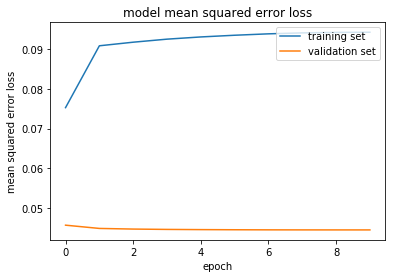

NameError: name 'training_producer1' is not defined

In [49]:
epochs = 10

from datetime import datetime
start_time = datetime.now()

model.compile(loss='mse', optimizer='adam')

numper_of_train_samples      = len(training_samples)
number_of_validation_samples = len(validation_samples) 

history_object = model.fit_generator(train_generator, steps_per_epoch= \
                                     numper_of_train_samples/32, 
                                     validation_data=validation_generator, \
                                     validation_steps=number_of_validation_samples/32, 
                                     epochs=epochs, verbose = 1,\
                                     workers=2)

end_time = datetime.now()
print('\nTotal number of train samples: {} ( shape {}x{})'.format(numper_of_train_samples,resized_shape,resized_shape))
print('\nBatch Size                   : {}'.format(batch_size))
print('\nDuration                     : {}'.format(end_time - start_time))

from keras.models import save_model

save_model(model, "selfdrive_model.h5")
print ( "  ")
print ( " .. model saved to selfdrive_model.h5 ")
print ( "  ")


### print the keys contained in the history object
# print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()


In [ ]:
training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()

#### Image Convolution broken down in small pieces 

### Here I am trying to visualize the Convolution Layers to understand visually how many filters I should use

In [ ]:
# print (" Loading drive.h5 .......")

# from keras.models import load_model
# from keras.models import Model

# modelobj = load_model('drive.h5')
# print (" ..... model drive.h5 successfully loaded")


#### For this purpose I am loading a Test image from disk

In [ ]:
plt.imshow(py_training_samples_part1[3000], cmap='gray')

plt.show()

In [ ]:
# # Load test images
# import cv2
# import numpy as np
# test_images = []

# image = cv2.imread('./test_images/center1.jpg')
# image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image,(resized_shape,resized_shape ))     
# test_images.append(image)


# test_images = np.array(test_images)


#### First of all I am looking at the Image Crop if is well done in the right position:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'cropping'
# intermediate_layer_model = Model(inputs=modelobj.input,
#                                  outputs=modelobj.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# intermediate_output.shape


In [ ]:
# # Show the cropped images
# def show_intermediate_output(image_ori, intermediate_output):
#     print (intermediate_output.shape)
#     depth = 0 
#     %matplotlib inline
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(20, 100))
#     new_image = []
#     plt.subplot(40, 5, 1 )
#     plt.axis('off')
#     plt.imshow(image_ori)
#     for i in range(0,intermediate_output[0,0].shape[0]):
#            single_output = intermediate_output[:,:,i]
# #            print ( "single_output.shape {}".format(single_output.shape ))
# #            print ( single_output)
#            plt.subplot(40, 5, i+2 )
#            plt.axis('off')
#            single_output = single_output.astype(np.uint8)
#            plt.imshow(single_output, cmap='gray')
#     plt.show()    

    
# show_intermediate_output(test_images[0], intermediate_output[0])

#### Now the FIRST convolutional layer:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv1'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

#### Now the SECOND convolutional layer:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv2'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 3

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv3'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 4

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv4'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Model Visualization

In [ ]:
# import cv2
# from keras.utils.visualize_util import plot
# from keras.models import load_model
# %matplotlib inline

# #visualize the model
# modelobj = load_model('model.h5')
# plot (modelobj, to_file='model.png')
# import matplotlib.pyplot as plt

# plt.figure(figsize=(100, 100))
# image = cv2.imread('model.png')
# image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
# plt.subplot(5, 5, 1)
# plt.axis('off')

# plt.imshow(image)
# plt.show()
